In [14]:
import pandas as pd
import numpy as np

import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from lightgbm import LGBMClassifier

import shap

## 1.  Model - No filter selection

#### 1. Load dataset 

In [15]:
df = pd.read_csv("./dataset/data-t1.csv")

In [16]:
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### 2. Clean dataset 

In [17]:
x = df.drop(columns=['diagnosis', 'id', 'Unnamed: 32'])
y = df['diagnosis'].map({"M": 0, "B": 1})

print(x.shape)

(569, 30)


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

#### 3. Train Model

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

model = LGBMClassifier()
start = time.time()
model.fit(x_train, y_train)
stop = time.time()

print(f"Training time: {(stop - start) * 1000 }ms")

y_test_pred = model.predict(x_test)
print_score(y_test, y_test_pred, train=False)

Training time: 231.64606094360352ms
Test Result:
Accuracy Score: 96.49%
_______________________________________________
Classification Report:
                   0           1  accuracy   macro avg  weighted avg
precision   0.966102    0.964286  0.964912    0.965194      0.964934
recall      0.934426    0.981818  0.964912    0.958122      0.964912
f1-score    0.950000    0.972973  0.964912    0.961486      0.964778
support    61.000000  110.000000  0.964912  171.000000    171.000000
_______________________________________________
Confusion Matrix: 
 [[ 57   4]
 [  2 108]]



#### 4. Model Results

## 2. Apply Feature Selection (Shap)

In [20]:
shap.initjs()

explainer = shap.Explainer(model)

start = time.time()
shap_values = explainer.shap_values(x_train)
stop = time.time()

print(f"Training time: {(stop - start) * 1000 }ms")

Training time: 53.29585075378418ms


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [21]:
import matplotlib.pyplot as plt

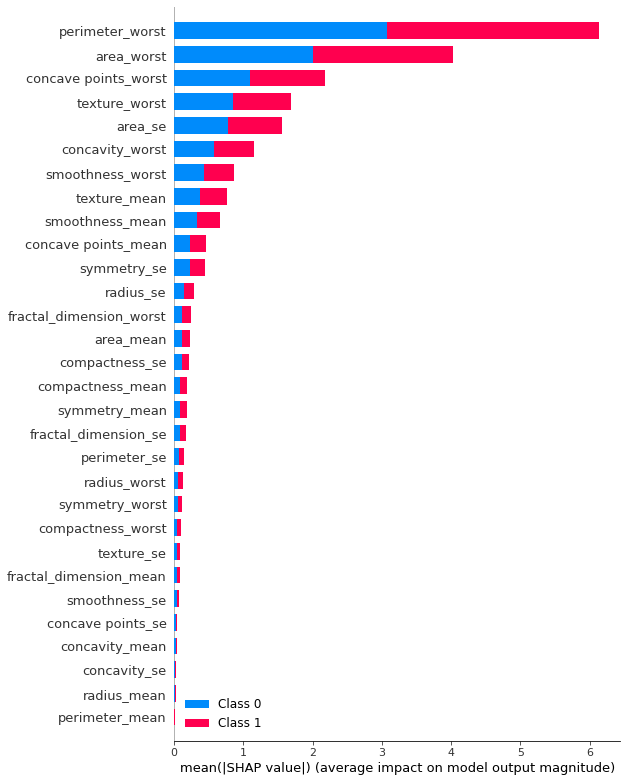

In [22]:
shap.summary_plot(shap_values, x_train, max_display=len(x.columns))

In [23]:
vals= np.abs(shap_values[1]).mean(0)
feature_importance = pd.DataFrame(list(zip(x_train.columns,vals)),columns=['feature_name','importance_value'])
feature_importance.sort_values(by=['importance_value'],ascending=False,inplace=True)

print(feature_importance.to_latex())

\begin{tabular}{llr}
\toprule
{} &             feature\_name &  importance\_value \\
\midrule
22 &          perimeter\_worst &          3.067913 \\
23 &               area\_worst &          2.010242 \\
27 &     concave points\_worst &          1.091286 \\
21 &            texture\_worst &          0.845797 \\
13 &                  area\_se &          0.779828 \\
26 &          concavity\_worst &          0.579315 \\
24 &         smoothness\_worst &          0.435708 \\
1  &             texture\_mean &          0.382548 \\
4  &          smoothness\_mean &          0.328932 \\
7  &      concave points\_mean &          0.231214 \\
18 &              symmetry\_se &          0.224602 \\
10 &                radius\_se &          0.143489 \\
29 &  fractal\_dimension\_worst &          0.121895 \\
3  &                area\_mean &          0.116129 \\
15 &           compactness\_se &          0.110739 \\
5  &         compactness\_mean &          0.092209 \\
8  &            symmetry\_mean &         

In [24]:
def get_feature_names(df, p_value=None):
    filtered_array = []
    for index, row in df.iterrows():
        if p_value != None:
            if row['importance_value'] >= p_value:
                filtered_array.append(row['feature_name'])
    
    return filtered_array

def get_sum(df):
    value = 0
    for index, row in df.iterrows():
        value = value + row['importance_value']

    return value

In [25]:
import os

measures_data = []
featured_names = []

def get_measures(feature, classification_report, training_time, shap_value, storage): 
    accuracy = classification_report["accuracy"]
    measures_data.append([feature, accuracy, training_time, shap_value, storage])

def train_model(feature, shap_value):
    featured_names.append(feature)
    
    x = df[featured_names]
    y = df['diagnosis'].map({"M": 0, "B": 1})
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

    model = LGBMClassifier()
    start = time.time()
    model.fit(x_train, y_train)
    stop = time.time()
    
    predict = model.predict(x_test)
    
    storage = get_storage(featured_names)
    training_time = (stop - start) * 1000
    classification = classification_report(y_test, predict, output_dict=True)
    get_measures(feature, classification, training_time, shap_value, storage)
    
def get_storage(features):
    merged_features = ['diagnosis', 'id', 'Unnamed: 32'] + features
    temp = df[merged_features]
    temp.to_csv('./dataset/temp.csv')
    
    return os.stat('./dataset/temp.csv').st_size
            
def shap_all(df):
    for index, row in df.iterrows():
        train_model(row['feature_name'], row['importance_value'])

In [26]:
shap_all(feature_importance)

measures_df = pd.DataFrame(measures_data, columns = ['Feature Name', 'Accuracy', 'Training Time', 'Shap Value', 'Storage'])

measures_df.to_csv('./results/catboost/cancer-breast-catboost-report.csv')

In [27]:
measures_df.head()

,Feature Name,Accuracy,Training Time,Shap Value,Storage
0,perimeter_worst,0.888889,105.159998,3.067913,11509
1,area_worst,0.842105,54.100990,2.010242,15087
2,concave points_worst,0.929825,80.205917,1.091286,19264
3,texture_worst,0.935673,77.538013,0.845797,22629
4,area_se,0.941520,68.665028,0.779828,26008


In [28]:
import matplotlib.pyplot as plt

def show_accuracy_chart(df):
    temp_1 = df['Accuracy'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Accuracy (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/catboost/catboost-accuracy.png')
    
def show_storage_chart(df):
    temp_1 = df['Storage'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Storage (bytes)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/catboost/catboost-storage.png')
    
def show_training_chart(df):
    temp_1 = df['Training Time'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Time (ms)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/catboost/catboost-training-time.png')

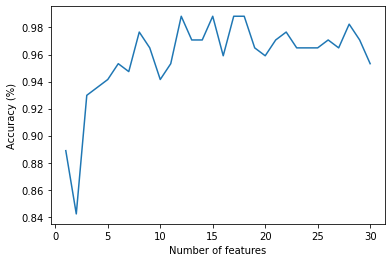

In [29]:
show_accuracy_chart(measures_df)

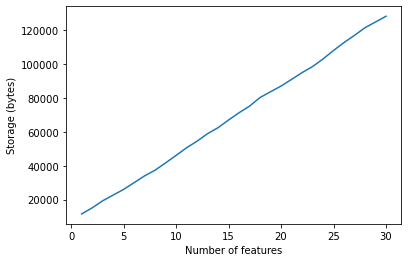

In [30]:
show_storage_chart(measures_df)

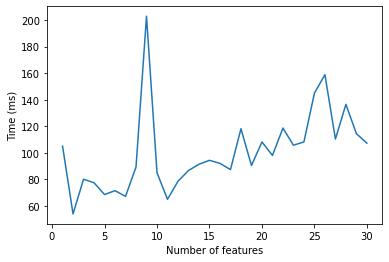

In [31]:
show_training_chart(measures_df)